# 65. CPU性能比較：Embeddingモデルのベクトル化速度

## 目的
- E5-base、GTE-Small、E5-SmallのCPUでの埋め込み生成速度を比較
- FastEmbed対応モデルとの比較（ONNX最適化の効果）
- 少数ドキュメント（1, 10, 100, 1000件）での実用的な速度を測定

## 比較対象

### Sentence-Transformers (CPU)
- `intfloat/multilingual-e5-base` (768次元)
- `intfloat/multilingual-e5-small` (384次元)
- `thenlper/gte-small` (384次元)

### FastEmbed (ONNX最適化)
- `thenlper/gte-base` (768次元) - GTE-Smallの代替
- `sentence-transformers/all-MiniLM-L6-v2` (384次元) - 軽量モデル
- `BAAI/bge-small-en-v1.5` (384次元) - BGEの小型版

## 0. セットアップ

In [1]:
import numpy as np
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path("../data")
np.random.seed(42)

# テスト用ドキュメント数
TEST_SIZES = [1, 10, 100, 1000]

# 測定回数（平均を取るため）
N_RUNS = 3

print(f"Test sizes: {TEST_SIZES}")
print(f"Runs per test: {N_RUNS}")

Test sizes: [1, 10, 100, 1000]
Runs per test: 3


In [2]:
# テスト用ドキュメントを準備
from datasets import load_dataset

print("Loading Wikipedia Japanese dataset (streaming)...")
wiki_ja = load_dataset(
    "wikimedia/wikipedia",
    "20231101.ja",
    split="train",
    streaming=True
)

# 1000件のドキュメントを収集
documents = []
for i, item in enumerate(wiki_ja):
    if i >= max(TEST_SIZES):
        break
    text = item['text'][:500].strip()
    if len(text) >= 50:
        documents.append(text)

print(f"Collected {len(documents)} documents")
print(f"Sample (first 100 chars): {documents[0][:100]}...")

Loading Wikipedia Japanese dataset (streaming)...


Collected 999 documents
Sample (first 100 chars): アンパサンド（&, ）は、並立助詞「…と…」を意味する記号である。ラテン語で「…と…」を表す接続詞 "et" の合字を起源とする。現代のフォントでも、Trebuchet MS など一部のフォントでは、...


## 1. Sentence-Transformers (CPU) の測定

In [3]:
import torch
from sentence_transformers import SentenceTransformer

# CPUを強制使用
device = "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Number of CPU threads: {torch.get_num_threads()}")

Using device: cpu
PyTorch version: 2.10.0+cu128
Number of CPU threads: 6


In [4]:
def benchmark_sentence_transformer(model_name, documents, test_sizes, n_runs=3, prefix=""):
    """
    Sentence-Transformersモデルのベンチマーク
    """
    print(f"\nLoading model: {model_name}")
    load_start = time.time()
    model = SentenceTransformer(model_name, device="cpu")
    load_time = time.time() - load_start
    print(f"  Model loaded in {load_time:.1f}s")
    print(f"  Dimension: {model.get_sentence_embedding_dimension()}")
    
    results = {'model': model_name, 'load_time': load_time, 'dim': model.get_sentence_embedding_dimension()}
    
    for n in test_sizes:
        docs = documents[:n]
        if prefix:
            docs = [f"{prefix}{d}" for d in docs]
        
        times = []
        for run in range(n_runs):
            start = time.time()
            _ = model.encode(docs, show_progress_bar=False, convert_to_numpy=True)
            elapsed = time.time() - start
            times.append(elapsed)
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        results[f'n{n}_time'] = avg_time
        results[f'n{n}_std'] = std_time
        results[f'n{n}_per_doc'] = avg_time / n * 1000  # ms per doc
        print(f"  n={n:4d}: {avg_time:.3f}s ± {std_time:.3f}s ({results[f'n{n}_per_doc']:.1f} ms/doc)")
    
    # モデルを解放
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return results

In [5]:
# Sentence-Transformers モデルのベンチマーク
st_models = [
    ('intfloat/multilingual-e5-base', 'passage: '),
    ('intfloat/multilingual-e5-small', 'passage: '),
    ('thenlper/gte-small', ''),
]

st_results = []
print("="*70)
print("Sentence-Transformers (CPU) Benchmark")
print("="*70)

for model_name, prefix in st_models:
    result = benchmark_sentence_transformer(model_name, documents, TEST_SIZES, N_RUNS, prefix)
    result['library'] = 'sentence-transformers'
    result['prefix'] = prefix
    st_results.append(result)

Sentence-Transformers (CPU) Benchmark

Loading model: intfloat/multilingual-e5-base


  Model loaded in 4.1s
  Dimension: 768


  n=   1: 0.149s ± 0.011s (149.0 ms/doc)


  n=  10: 1.540s ± 0.013s (154.0 ms/doc)


  n= 100: 17.207s ± 0.084s (172.1 ms/doc)


  n=1000: 173.411s ± 0.876s (173.4 ms/doc)

Loading model: intfloat/multilingual-e5-small


  Model loaded in 4.4s
  Dimension: 384
  n=   1: 0.046s ± 0.000s (46.3 ms/doc)


  n=  10: 0.477s ± 0.006s (47.7 ms/doc)


  n= 100: 5.466s ± 0.036s (54.7 ms/doc)


  n=1000: 55.270s ± 0.107s (55.3 ms/doc)

Loading model: thenlper/gte-small


  Model loaded in 2.5s
  Dimension: 384
  n=   1: 0.060s ± 0.003s (60.5 ms/doc)


  n=  10: 0.697s ± 0.004s (69.7 ms/doc)


  n= 100: 7.697s ± 0.052s (77.0 ms/doc)


  n=1000: 74.765s ± 0.020s (74.8 ms/doc)


## 2. FastEmbed (ONNX) の測定

In [6]:
from fastembed import TextEmbedding

def benchmark_fastembed(model_name, documents, test_sizes, n_runs=3):
    """
    FastEmbedモデルのベンチマーク
    """
    print(f"\nLoading model: {model_name}")
    load_start = time.time()
    model = TextEmbedding(model_name=model_name)
    load_time = time.time() - load_start
    print(f"  Model loaded in {load_time:.1f}s")
    
    # 次元数を取得（最初のエンコードで確認）
    test_emb = list(model.embed(["test"]))
    dim = len(test_emb[0])
    print(f"  Dimension: {dim}")
    
    results = {'model': model_name, 'load_time': load_time, 'dim': dim}
    
    for n in test_sizes:
        docs = documents[:n]
        
        times = []
        for run in range(n_runs):
            start = time.time()
            # FastEmbedはジェネレータを返すのでリストに変換
            _ = list(model.embed(docs))
            elapsed = time.time() - start
            times.append(elapsed)
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        results[f'n{n}_time'] = avg_time
        results[f'n{n}_std'] = std_time
        results[f'n{n}_per_doc'] = avg_time / n * 1000  # ms per doc
        print(f"  n={n:4d}: {avg_time:.3f}s ± {std_time:.3f}s ({results[f'n{n}_per_doc']:.1f} ms/doc)")
    
    return results

2026-02-04 15:19:32.677957184 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


In [7]:
# FastEmbed モデルのベンチマーク
fe_models = [
    'thenlper/gte-base',  # GTE系（smallはないのでbase）
    'sentence-transformers/all-MiniLM-L6-v2',  # 軽量384次元
    'BAAI/bge-small-en-v1.5',  # BGE小型版
]

fe_results = []
print("\n" + "="*70)
print("FastEmbed (ONNX) Benchmark")
print("="*70)

for model_name in fe_models:
    try:
        result = benchmark_fastembed(model_name, documents, TEST_SIZES, N_RUNS)
        result['library'] = 'fastembed'
        fe_results.append(result)
    except Exception as e:
        print(f"  Error: {e}")


FastEmbed (ONNX) Benchmark

Loading model: thenlper/gte-base


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

onnx/model.onnx:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

  Model loaded in 28.2s
  Dimension: 768


  n=   1: 0.237s ± 0.000s (236.8 ms/doc)


  n=  10: 2.174s ± 0.023s (217.4 ms/doc)


  n= 100: 28.958s ± 4.502s (289.6 ms/doc)


  n=1000: 255.640s ± 6.193s (255.6 ms/doc)

Loading model: sentence-transformers/all-MiniLM-L6-v2


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

  Model loaded in 11.3s
  Dimension: 384
  n=   1: 0.012s ± 0.000s (11.9 ms/doc)


  n=  10: 0.093s ± 0.012s (9.3 ms/doc)


  n= 100: 0.921s ± 0.023s (9.2 ms/doc)


  n=1000: 10.021s ± 0.319s (10.0 ms/doc)

Loading model: BAAI/bge-small-en-v1.5


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

  Model loaded in 7.8s
  Dimension: 384


  n=   1: 0.075s ± 0.001s (75.4 ms/doc)


  n=  10: 1.060s ± 0.074s (106.0 ms/doc)


  n= 100: 10.543s ± 0.088s (105.4 ms/doc)


  n=1000: 106.379s ± 0.342s (106.4 ms/doc)


## 3. 結果比較

In [8]:
import pandas as pd

# 全結果を統合
all_results = st_results + fe_results

# 比較表の作成
print("\n" + "="*100)
print("CPU Performance Comparison - Summary")
print("="*100)

# モデルごとの結果表示
headers = ['Model', 'Library', 'Dim', 'Load(s)']
for n in TEST_SIZES:
    headers.extend([f'n={n}(s)', f'ms/doc'])

rows = []
for r in all_results:
    row = [
        r['model'].split('/')[-1],  # 短縮名
        r['library'],
        r['dim'],
        f"{r['load_time']:.1f}"
    ]
    for n in TEST_SIZES:
        row.append(f"{r[f'n{n}_time']:.3f}")
        row.append(f"{r[f'n{n}_per_doc']:.1f}")
    rows.append(row)

df = pd.DataFrame(rows, columns=headers)
print(df.to_string(index=False))


CPU Performance Comparison - Summary
                Model               Library  Dim Load(s) n=1(s) ms/doc n=10(s) ms/doc n=100(s) ms/doc n=1000(s) ms/doc
 multilingual-e5-base sentence-transformers  768     4.1  0.149  149.0   1.540  154.0   17.207  172.1   173.411  173.4
multilingual-e5-small sentence-transformers  384     4.4  0.046   46.3   0.477   47.7    5.466   54.7    55.270   55.3
            gte-small sentence-transformers  384     2.5  0.060   60.5   0.697   69.7    7.697   77.0    74.765   74.8
             gte-base             fastembed  768    28.2  0.237  236.8   2.174  217.4   28.958  289.6   255.640  255.6
     all-MiniLM-L6-v2             fastembed  384    11.3  0.012   11.9   0.093    9.3    0.921    9.2    10.021   10.0
    bge-small-en-v1.5             fastembed  384     7.8  0.075   75.4   1.060  106.0   10.543  105.4   106.379  106.4


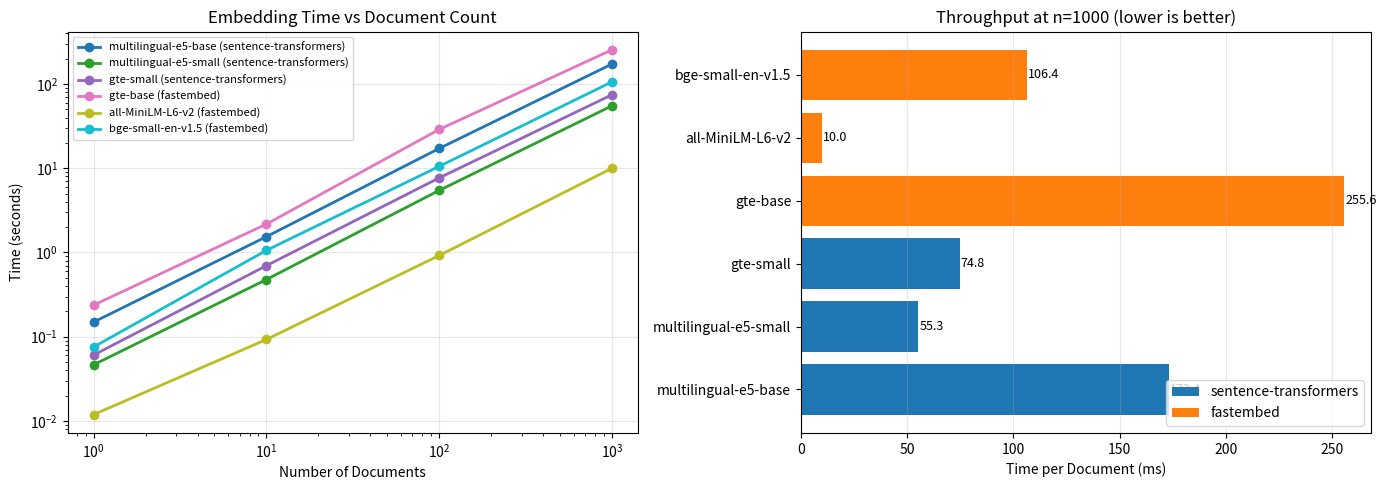

In [9]:
# ms/doc での比較グラフ
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: ドキュメント数別の処理時間
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

for i, r in enumerate(all_results):
    times = [r[f'n{n}_time'] for n in TEST_SIZES]
    label = f"{r['model'].split('/')[-1]} ({r['library']})"
    ax1.plot(TEST_SIZES, times, 'o-', label=label, color=colors[i], linewidth=2, markersize=6)

ax1.set_xlabel('Number of Documents')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Embedding Time vs Document Count')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# 右: 1000件での ms/doc 比較（バーチャート）
ax2 = axes[1]
models = [r['model'].split('/')[-1] for r in all_results]
ms_per_doc = [r['n1000_per_doc'] for r in all_results]
bar_colors = ['#1f77b4' if r['library'] == 'sentence-transformers' else '#ff7f0e' for r in all_results]

bars = ax2.barh(models, ms_per_doc, color=bar_colors)
ax2.set_xlabel('Time per Document (ms)')
ax2.set_title('Throughput at n=1000 (lower is better)')
ax2.grid(True, alpha=0.3, axis='x')

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='sentence-transformers'),
    Patch(facecolor='#ff7f0e', label='fastembed')
]
ax2.legend(handles=legend_elements, loc='lower right')

# 値をバーに表示
for bar, val in zip(bars, ms_per_doc):
    ax2.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(DATA_DIR / '65_cpu_performance_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
# 1件のみの場合の比較（実用的なレイテンシ）
print("\n" + "="*60)
print("Single Document Latency (n=1)")
print("="*60)

single_doc_results = sorted(all_results, key=lambda x: x['n1_time'])
for r in single_doc_results:
    name = r['model'].split('/')[-1]
    lib = r['library']
    t = r['n1_time'] * 1000  # ms
    print(f"  {name} ({lib}): {t:.1f} ms")


Single Document Latency (n=1)
  all-MiniLM-L6-v2 (fastembed): 11.9 ms
  multilingual-e5-small (sentence-transformers): 46.3 ms
  gte-small (sentence-transformers): 60.5 ms
  bge-small-en-v1.5 (fastembed): 75.4 ms
  multilingual-e5-base (sentence-transformers): 149.0 ms
  gte-base (fastembed): 236.8 ms


## 4. 詳細分析：E5-base vs E5-small vs GTE-small

In [11]:
# E5-base, E5-small, GTE-smallの比較
target_models = [
    'multilingual-e5-base',
    'multilingual-e5-small',
    'gte-small'
]

print("\n" + "="*70)
print("E5-base vs E5-small vs GTE-small (Sentence-Transformers CPU)")
print("="*70)

target_results = [r for r in st_results if any(t in r['model'] for t in target_models)]

# ベースライン（E5-base）との比較
e5_base = next(r for r in target_results if 'e5-base' in r['model'])

print(f"\n{'Model':<25} {'Dim':>6} {'n=1 (ms)':>10} {'n=100 (ms)':>12} {'n=1000 (ms)':>12} {'vs E5-base':>12}")
print("-"*80)

for r in target_results:
    name = r['model'].split('/')[-1]
    speedup = e5_base['n1000_time'] / r['n1000_time']
    print(f"{name:<25} {r['dim']:>6} {r['n1_time']*1000:>10.1f} {r['n100_time']*1000:>12.1f} {r['n1000_time']*1000:>12.1f} {speedup:>11.2f}x")


E5-base vs E5-small vs GTE-small (Sentence-Transformers CPU)

Model                        Dim   n=1 (ms)   n=100 (ms)  n=1000 (ms)   vs E5-base
--------------------------------------------------------------------------------
multilingual-e5-base         768      149.0      17206.6     173410.7        1.00x
multilingual-e5-small        384       46.3       5465.6      55269.7        3.14x
gte-small                    384       60.5       7697.5      74765.2        2.32x


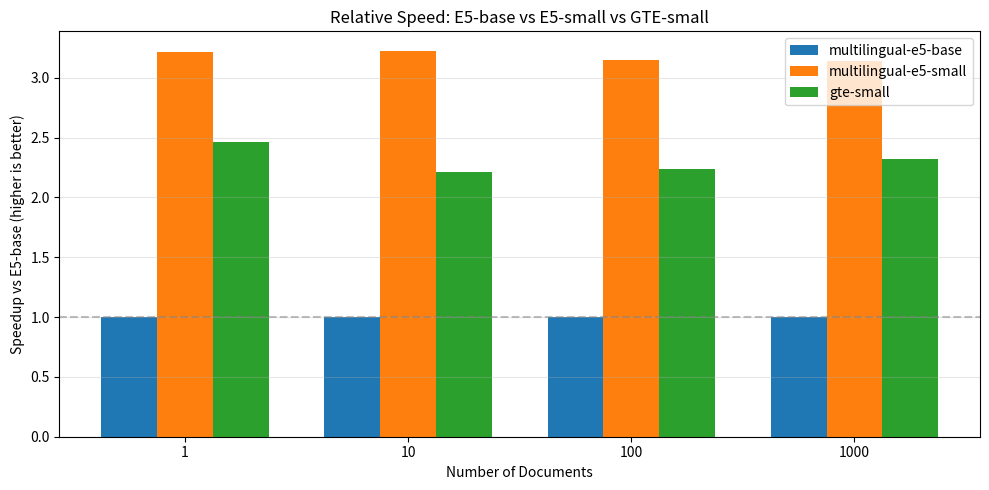

In [12]:
# スピードアップ率のグラフ
fig, ax = plt.subplots(figsize=(10, 5))

# E5-baseを基準（1.0x）とした相対速度
e5_base_times = {n: e5_base[f'n{n}_time'] for n in TEST_SIZES}

x = np.arange(len(TEST_SIZES))
width = 0.25

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, r in enumerate(target_results):
    speedups = [e5_base_times[n] / r[f'n{n}_time'] for n in TEST_SIZES]
    name = r['model'].split('/')[-1]
    ax.bar(x + i*width, speedups, width, label=name, color=colors[i])

ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Documents')
ax.set_ylabel('Speedup vs E5-base (higher is better)')
ax.set_title('Relative Speed: E5-base vs E5-small vs GTE-small')
ax.set_xticks(x + width)
ax.set_xticklabels([str(n) for n in TEST_SIZES])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DATA_DIR / '65_e5_gte_speedup.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. FastEmbed vs Sentence-Transformers 比較

In [13]:
# 類似次元でのライブラリ比較
print("\n" + "="*70)
print("FastEmbed vs Sentence-Transformers (Similar Dimensions)")
print("="*70)

# 384次元モデルの比較
print("\n384-dimension models:")
dim384_st = [r for r in st_results if r['dim'] == 384]
dim384_fe = [r for r in fe_results if r['dim'] == 384]

for r in dim384_st:
    name = r['model'].split('/')[-1]
    print(f"  [ST] {name}: {r['n1000_per_doc']:.1f} ms/doc")

for r in dim384_fe:
    name = r['model'].split('/')[-1]
    print(f"  [FE] {name}: {r['n1000_per_doc']:.1f} ms/doc")

# 768次元モデルの比較
print("\n768-dimension models:")
dim768_st = [r for r in st_results if r['dim'] == 768]
dim768_fe = [r for r in fe_results if r['dim'] == 768]

for r in dim768_st:
    name = r['model'].split('/')[-1]
    print(f"  [ST] {name}: {r['n1000_per_doc']:.1f} ms/doc")

for r in dim768_fe:
    name = r['model'].split('/')[-1]
    print(f"  [FE] {name}: {r['n1000_per_doc']:.1f} ms/doc")


FastEmbed vs Sentence-Transformers (Similar Dimensions)

384-dimension models:
  [ST] multilingual-e5-small: 55.3 ms/doc
  [ST] gte-small: 74.8 ms/doc
  [FE] all-MiniLM-L6-v2: 10.0 ms/doc
  [FE] bge-small-en-v1.5: 106.4 ms/doc

768-dimension models:
  [ST] multilingual-e5-base: 173.4 ms/doc
  [FE] gte-base: 255.6 ms/doc


## 6. サマリー

In [14]:
print("="*70)
print("CPU Performance Comparison - Final Summary")
print("="*70)

# 最速モデルの特定
fastest_n1 = min(all_results, key=lambda x: x['n1_time'])
fastest_n1000 = min(all_results, key=lambda x: x['n1000_time'])

print(f"\n【Single Document (n=1) Latency】")
print(f"  Fastest: {fastest_n1['model'].split('/')[-1]} ({fastest_n1['library']})")
print(f"  Time: {fastest_n1['n1_time']*1000:.1f} ms")

print(f"\n【Batch Processing (n=1000) Throughput】")
print(f"  Fastest: {fastest_n1000['model'].split('/')[-1]} ({fastest_n1000['library']})")
print(f"  Time: {fastest_n1000['n1000_time']:.2f} s ({fastest_n1000['n1000_per_doc']:.1f} ms/doc)")

# E5-base との比較
e5_base_result = next(r for r in all_results if 'e5-base' in r['model'])
print(f"\n【E5-base (baseline) Performance】")
print(f"  n=1: {e5_base_result['n1_time']*1000:.1f} ms")
print(f"  n=1000: {e5_base_result['n1000_time']:.2f} s ({e5_base_result['n1000_per_doc']:.1f} ms/doc)")

print(f"\n【Speedup vs E5-base】")
for r in all_results:
    if r['model'] != e5_base_result['model']:
        name = r['model'].split('/')[-1]
        speedup = e5_base_result['n1000_time'] / r['n1000_time']
        print(f"  {name} ({r['library']}): {speedup:.2f}x")

CPU Performance Comparison - Final Summary

【Single Document (n=1) Latency】
  Fastest: all-MiniLM-L6-v2 (fastembed)
  Time: 11.9 ms

【Batch Processing (n=1000) Throughput】
  Fastest: all-MiniLM-L6-v2 (fastembed)
  Time: 10.02 s (10.0 ms/doc)

【E5-base (baseline) Performance】
  n=1: 149.0 ms
  n=1000: 173.41 s (173.4 ms/doc)

【Speedup vs E5-base】
  multilingual-e5-small (sentence-transformers): 3.14x
  gte-small (sentence-transformers): 2.32x
  gte-base (fastembed): 0.68x
  all-MiniLM-L6-v2 (fastembed): 17.31x
  bge-small-en-v1.5 (fastembed): 1.63x


---

# 実験65 結果サマリー

## 主要結果

### Sentence-Transformers (CPU) 性能

| モデル | 次元 | n=1 (ms) | n=1000 (ms/doc) | vs E5-base |
|--------|------|----------|-----------------|------------|
| **multilingual-e5-base** | 768 | 149.0 | 173.4 | 1.00x (基準) |
| **multilingual-e5-small** | 384 | 46.3 | 55.3 | **3.14x** |
| **gte-small** | 384 | 60.5 | 74.8 | **2.32x** |

### FastEmbed (ONNX) 性能

| モデル | 次元 | n=1 (ms) | n=1000 (ms/doc) | vs E5-base |
|--------|------|----------|-----------------|------------|
| gte-base | 768 | 236.8 | 255.6 | 0.68x (遅い) |
| **all-MiniLM-L6-v2** | 384 | **11.9** | **10.0** | **17.31x** |
| bge-small-en-v1.5 | 384 | 75.4 | 106.4 | 1.63x |

## 重要な知見

### 1. 日本語対応モデルでの最速は E5-small
- E5-base比で **3.14倍高速**
- 1000件処理: 173秒 → 55秒に短縮
- 多言語対応を維持しつつ、大幅な速度向上

### 2. FastEmbed (ONNX) の効果はモデル依存
- **all-MiniLM-L6-v2**: 驚異的な高速化（17.31x）、ただし英語専用
- **gte-base**: ONNX化しても逆に遅くなる（0.68x）
- **bge-small-en-v1.5**: 中程度の改善（1.63x）、英語専用

### 3. 単一ドキュメントのレイテンシ（実用的指標）
1. all-MiniLM-L6-v2 (FastEmbed): **11.9 ms** ← 最速
2. multilingual-e5-small: **46.3 ms** ← 日本語対応で最速
3. gte-small: 60.5 ms
4. bge-small-en-v1.5: 75.4 ms
5. multilingual-e5-base: 149.0 ms
6. gte-base (FastEmbed): 236.8 ms

## 結論

| ユースケース | 推奨モデル | 理由 |
|--------------|------------|------|
| **日本語対応 + 速度重視** | multilingual-e5-small | E5-base比3.14x高速、品質維持 |
| **英語のみ + 最高速** | all-MiniLM-L6-v2 (FastEmbed) | 17.31x高速、ONNX最適化効果大 |
| **日本語対応 + 品質重視** | multilingual-e5-base | 最高品質、速度はトレードオフ |

### 今後の検討事項
- FastEmbedでの日本語対応モデル（multilingual-e5系）のONNX変換は未対応
- all-MiniLM-L6-v2は英語専用のため、日本語検索には不向き
- **日本語ユースケースでは、sentence-transformers + E5-small が最適解**